# Analysis script for umbrella sampling simulations

This notebook contains analysis for the various umbrella sampling simulations involved in the path-based binding free energy calculation for BRD4-DCAF16

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import red
import shutil
import subprocess 
import pickle

from analysis import *

### Generating PMFs

In [2]:
"""Defining constants"""

temperature = 298.15 # K
boltzmann = 0.0019872041 # kcal/mol K
beta = 1.0/(boltzmann*temperature)
k_boresch = 100 # kcal/mol rad**2
k_rmsd = 3000 # kcal/mol nm**-2
sep_cv_max = 4.0 # nm
standard_volume = 1660 # angstroms^3
standard_volume_nm = standard_volume*0.001 # nm^3
radius_sphere = (3*standard_volume_nm/(4*np.pi))**(1.0/3.0) # radius of sphere whose volume is equal to the standard volume in nm

/home/btan/Documents/CRBN_CK1a/umbrella_sampling/separation/results/backbone_RMSD/run1/RED


Applying RED:   0%|          | 0/38 [00:00<?, ?it/s]

Applying RED: 100%|██████████| 38/38 [00:13<00:00,  2.80it/s]


Successfully ran /home/btan/Software/WHAM/wham/wham/wham 0.0 3.4 200 1e-06 300 0 /home/btan/Documents/CRBN_CK1a/umbrella_sampling/separation/results/backbone_RMSD/run1/RED/metafile.txt /home/btan/Documents/CRBN_CK1a/umbrella_sampling/separation/results/backbone_RMSD/run1/RED/pmf.txt > /home/btan/Documents/CRBN_CK1a/umbrella_sampling/separation/results/backbone_RMSD/run1/RED/wham.log 


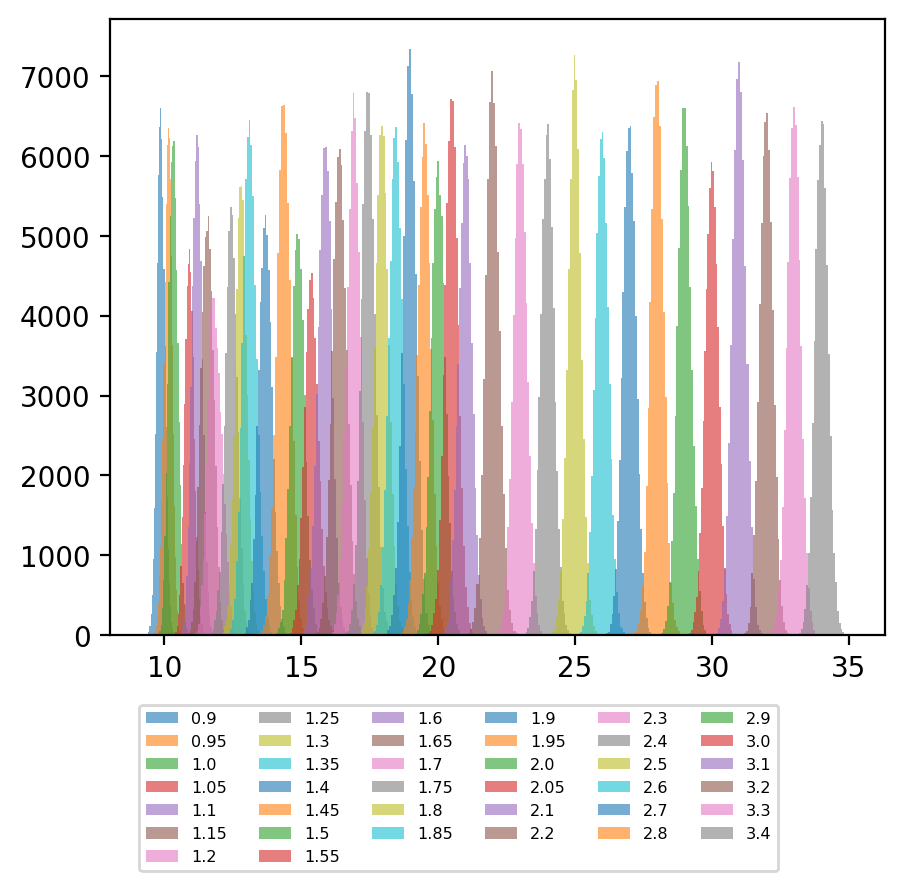

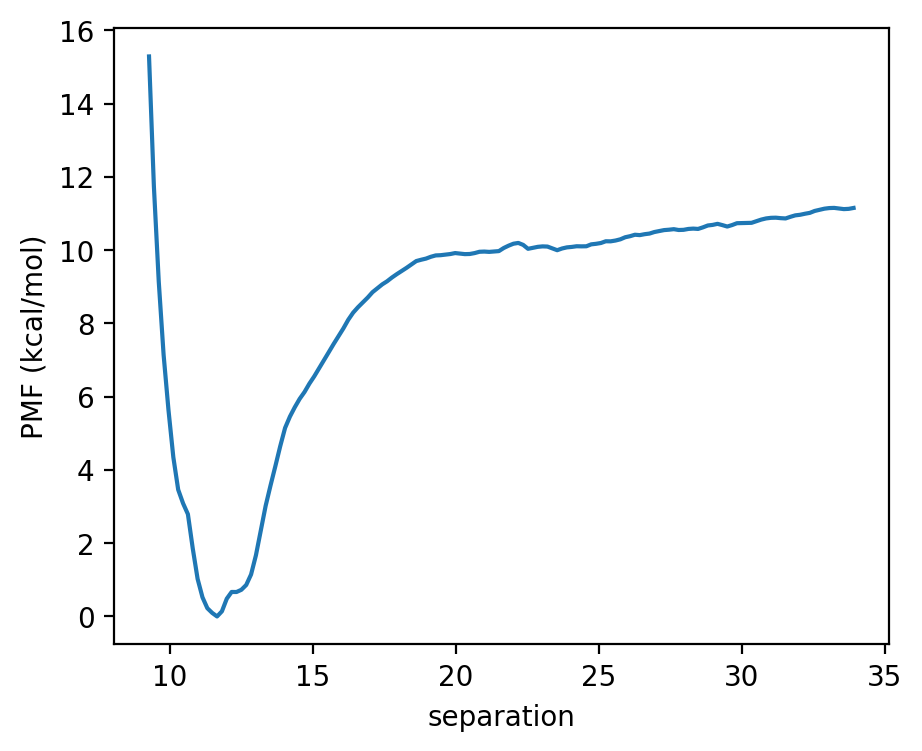

In [3]:
"""Perform WHAM for a single run"""

free_energies = []
data = []

for n_run in [1]:

    wham_params = [0.0, 3.4, 200, 1e-6, 300, 0]

    k = 1000 # Force constant for WHAM metafile, units are kcal mol-1 / nm^2
    ignore_values = []
    # ignore_values = np.round(np.arange(2.1, 4.1, 0.05), 3)

    free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, plot = [
        'separation', 'backbone', None, 'RED', None, n_run, True
    ]

    if dof in ['DCAF16', 'BD1', 'BD2']:
        unbound = True
    else:
        unbound = False

    generate_metafile(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, k, ignore_values, plot=plot)
    perform_WHAM(wham_params, free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number)
    x,pmf = obtain_PMF(free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, plot=plot)

    # data.append([x,pmf])
    # free_energies.append(RMSDContribution(3000, free_energy_step, restraint_type, dof, equilibration, sampling_time, run_number, unbound))

# x, av, err = obtain_av_PMF(free_energy_step, restraint_type, dof, equilibration, sampling_time, plot_indiv=True, plot_av=True)

In [40]:
free_energies

[-23.942657371193732, -22.616814577767325, -24.22247724632552]

In [41]:
"""Find average and st error"""

free_energies = np.array(free_energies)

print(f"The average free energy change for {dof} is {np.average(free_energies)} kcal/mol")
print(f"The standard error is {np.std(free_energies)/np.sqrt(len(free_energies))} kcal/mol")

The average free energy change for DCAF16withBD2 is -23.59398306509553 kcal/mol
The standard error is 0.4043426709831804 kcal/mol


In [ ]:
"""Restrain DCAF16 first"""

7.39 + 28.1 - 25.3 -23.6

-13.41

In [ ]:
"""Restrain BD2 first"""

7.39 + 28.1 - 11.7- 11.5

12.290000000000003

### Analysing the timeseries

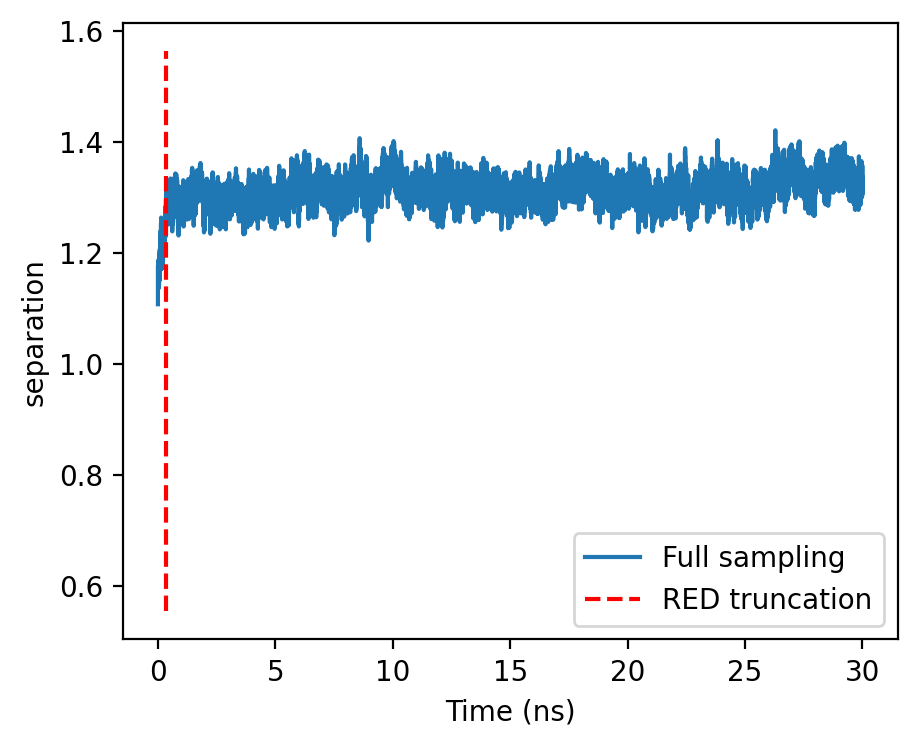

(array([0.00000000e+00, 5.00008333e-04, 1.00001667e-03, ...,
        2.99990000e+01, 2.99995000e+01, 3.00000000e+01]),
 array([1.1072638 , 1.13611555, 1.12957954, ..., 1.31002748, 1.32232809,
        1.30894232]))

In [5]:
plot_timeseries(1.35, 'separation', 'backbone', None, 'RED', None, 1)

### Analysing restrained DOFs in separation US

In [6]:
run_number = 1
r0 = 1.35

<Axes: xlabel='Time (ns)'>

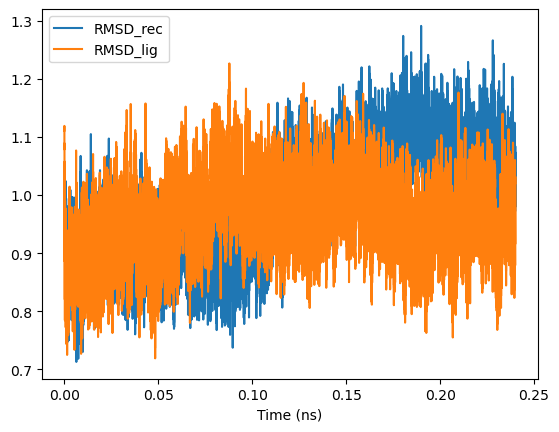

In [8]:
df_RMSD = pd.read_csv(f'separation/results/backbone_RMSD/run{run_number}/{r0}_RMSD.csv')
df_RMSD.plot(x='Time (ns)', y=['RMSD_rec', 'RMSD_lig'], legend=True)

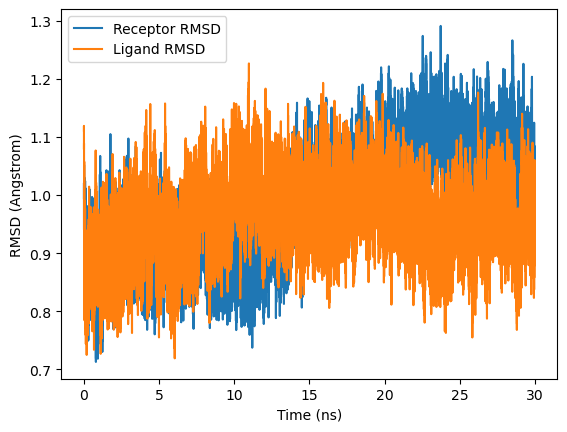

In [11]:
time = df_RMSD['Steps'].to_numpy()*5e-4
rec_RMSD = df_RMSD['RMSD_rec'].to_numpy()
lig_RMSD = df_RMSD['RMSD_lig'].to_numpy()

plt.plot(time, rec_RMSD, label='Receptor RMSD')
plt.plot(time, lig_RMSD, label='Ligand RMSD')
plt.ylabel('RMSD (Angstrom)')
plt.xlabel('Time (ns)')
plt.legend()

In [12]:
def obtain_CA_idx(u, res_idx):
    """Function to obtain the index of the alpha carbon for a given residue index"""
    
    selection_str = f"protein and resid {res_idx} and name CA"
    
    selected_CA = u.select_atoms(selection_str)

    if len(selected_CA.indices) == 0:
        print('CA not found for the specified residue...')
    
    elif len(selected_CA.indices) > 1:
        print('Multiple CAs found, uh oh...')

    else:  
        return selected_CA.indices[0]

def obtain_angle(pos1, pos2, pos3):

    return mda.lib.distances.calc_angles(pos1, pos2, pos3)

def obtain_dihedral( pos1, pos2, pos3, pos4):
    
    return mda.lib.distances.calc_dihedrals(pos1, pos2, pos3, pos4)


In [10]:
import MDAnalysis as mda

u = mda.Universe('/home/btan/Documents/BD2_DCAF16/umbrella_sampling/separation/windows/2.8/system.prmtop',
                 '/home/btan/Documents/BD2_DCAF16/umbrella_sampling/separation/results/backbone_RMSD/run1/2.8.dcd')

rec_group = [160, 215, 226, 245, 264, 286, 307, 318, 332, 346, 920, 930, 941, 958, 1982, 1999, 2026, 2032, 2046, 2057, 2068, 2084, 2095, 2102, 2112, 2123, 2133, 2140, 2164, 2183, 2197, 2219, 2286, 2300, 2314, 2338, 2352, 2375, 2381, 2400, 2414, 2428, 2442, 2463, 2474, 2521]
lig_group = [3045, 3055, 3096, 3128, 3134, 3154, 3175, 3205, 3211, 3227, 3239, 3255, 3270, 3280, 3299, 3306, 3325, 3342, 3354, 3375, 3398, 3535, 4040, 4061, 4083, 4097, 4103, 4115, 4132, 4147]

rec_str = ' '.join(map(str, rec_group))
lig_str = ' '.join(map(str, lig_group))

/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/topology/TOPParser.py:342: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using universe.guess_TopologyAttrs(to_guess=['elements']).
  warnings.warn(msg)
/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [11]:
res_b = 11
res_c = 6
res_B = 262
res_C = 241

# Define anchor points
idx_b = obtain_CA_idx(u, res_b)
idx_c = obtain_CA_idx(u, res_c)
idx_B = obtain_CA_idx(u, res_B)
idx_C = obtain_CA_idx(u, res_C)

group_a = rec_group
group_b = [idx_b]
group_c = [idx_c]
group_A = lig_group
group_B = [idx_B]
group_C = [idx_C]

all_atoms = group_a + group_b + group_c + group_A + group_B + group_C 
for atom in u.atoms[all_atoms]:
    if atom.name != 'CA':
        raise ValueError('Select only CA atoms as anchorpoints')
    
pos_a = u.atoms[group_a].center_of_mass()
pos_b = u.atoms[group_b].center_of_mass()
pos_c = u.atoms[group_c].center_of_mass()
pos_A = u.atoms[group_A].center_of_mass()
pos_B = u.atoms[group_B].center_of_mass()
pos_C = u.atoms[group_C].center_of_mass()

In [12]:
obtain_dihedral(pos_a, pos_A, pos_B, pos_C)

2.940926111942796

### Analysis Boresch DOFs in separation US

In [13]:
eq_values = {
    'thetaA' : 1.27,
    'thetaB' : 1.93,
    'phiA' : -2.81,
    'phiB' : -0.24,
    'phiC' : 2.82
}

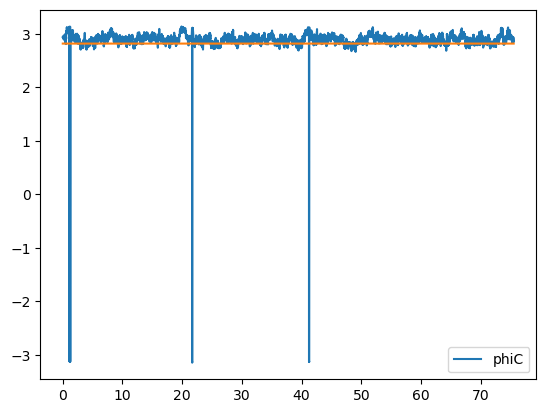

In [17]:
run_number = 1
r0 = 2.8
dofs = ['phiC']

boreschfile = f"separation/results/backbone_RMSD/run{run_number}/{r0}_boresch.pkl"

with open(boreschfile, 'rb') as f:
    boresch_data = pickle.load(f)

for dof in dofs:

    plt.plot(boresch_data['Time (ns)'], boresch_data[dof], label=dof)
    plt.plot(boresch_data['Time (ns)'], eq_values[dof]*np.ones(len(boresch_data['Time (ns)'])))

plt.legend()

## Comparing cos and harmonic potentials

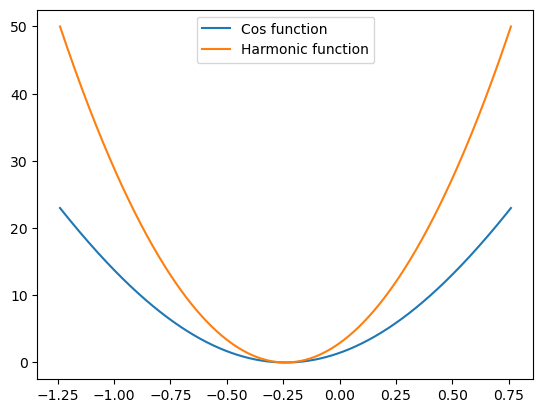

In [103]:
theta_A_0 = 1.27
theta_B_0 = 1.93
phi_A_0 = -2.81
phi_B_0 = -0.24
phi_C_0 = 2.82

k_boresch = 100

dof = phi_B_0 # Choose the Boresch dof

x = np.linspace(dof-1, dof+1, 1000)

def cos(x, k):
    return -0.5 * k * np.cos(x - np.median(x)) + 0.5 * k 

def harmonic(x, k):
    return 0.5 * k *np.square(x - np.median(x))

plt.plot(x, cos(x, k_boresch), label='Cos function')
plt.plot(x, harmonic(x, k_boresch), label='Harmonic function')
plt.legend()
plt.show()

In [2]:
import openmm as mm
import openmm.app as app
import openmm.unit as unit
import sys
import os
from sys import stdout
import numpy as np
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
from MDAnalysis.analysis.distances import dist

/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [3]:
r0 = 1.5
jobid = 102764

"""Read global params from params.in"""

def read_param(param_str, jobid):
    """
    Read in a specific parameter and assign the parameter value to a variable
    """
    with open(f'separation/jobs/{jobid}.in', 'r') as file:
        for line in file:
            line = line.strip()

            if line.startswith(param_str):
                parts = line.split(' = ')
                part = parts[1].strip()

    values = part.split(' ')
    value = values[0].strip()

    # Attempt int conversion
    try:
        value = int(value)
    except:
        value = str(value)

    return value

# MD parameters
timestep = read_param('timestep', jobid)
save_traj = read_param('save_traj', jobid)
equil_steps = int(read_param('equilibration_time', jobid)//(timestep*1e-6))
sampling_steps = int(read_param('sampling_time', jobid)//(timestep*1e-6))
record_steps = read_param('n_steps_between_sampling', jobid)

# Force constants
k_Boresch = read_param('k_Boresch', jobid)
k_RMSD = read_param('k_RMSD', jobid)
k_sep = read_param('k_sep', jobid)

# Directory to save all results
run_number = read_param('run_number', jobid)
restraint_type = read_param('RMSD_restraint', jobid)
inputdir = f"separation/windows/{r0}"
savedir = f"separation/results/{restraint_type}_RMSD/run{run_number}"

if not os.path.exists(inputdir): # Check if directory exists
    raise FileNotFoundError(f"Input directory does not exist for r0 = {r0}")

if os.path.exists(f'{savedir}/{r0}.txt'): # Check if a CV sample file already exists
    raise FileExistsError(f"A file of CV samples already exists for r0 = {r0}")

if not os.path.exists(savedir): # Make save directory if it doesn't yet exist
    os.makedirs(savedir)

"""Selection tuple for restraint type"""

if restraint_type == 'backbone':
    restraint_tuple = ('C', 'N', 'CA')

elif restraint_type == 'CA':
    restraint_tuple = ('CA')

elif restraint_type != 'heavy_atom':
    raise ValueError('Select one of the following restraint type options:  heavy_atom, backbone, CA')

"""System setup"""

dt = timestep*unit.femtoseconds 

# Load param and coord files
prmtop = app.AmberPrmtopFile(f'{inputdir}/system.prmtop')
inpcrd = app.AmberInpcrdFile(f'{inputdir}/system.inpcrd')

system = prmtop.createSystem(nonbondedMethod=app.PME, hydrogenMass=1.5*unit.amu, nonbondedCutoff=1.0*unit.nanometer, constraints=app.HBonds)  
integrator = mm.LangevinMiddleIntegrator(0.0000*unit.kelvin, 1.0000/unit.picosecond, dt)

simulation = app.Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)

# Add reporters to output data
simulation.reporters.append(app.StateDataReporter(f'{savedir}/{r0}.csv', 1000, step=True, time=True, potentialEnergy=True, kineticEnergy=True, totalEnergy=True, temperature=True, volume=True, density=True, speed=True))
simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, time=True, potentialEnergy=True, temperature=True, speed=True))

if save_traj=='True':
    simulation.reporters.append(app.DCDReporter(f'{savedir}/{r0}.dcd', 1000))

# Minimise energy 
# simulation.minimizeEnergy()


"""System heating"""

# for i in range(50):
#     integrator.setTemperature(6*(i+1)*unit.kelvin)
#     simulation.step(1000)

# simulation.step(1000)
# simulation.context.setVelocitiesToTemperature(300*unit.kelvin)

"""RMSD Restraints"""

# Make lists of residue indices distinguising between interface and DDB1-binding regions of DCAF16
DCAF16_interface_residx = np.append(np.arange(0,55), np.arange(123, 172))
DCAF16_DDB1_binding_residx = np.arange(71,114)

reference_positions = simulation.context.getState(getPositions=True).getPositions()
# reference_positions = inpcrd.positions

receptor_atoms = [
    atom.index for atom in simulation.topology.atoms()
    if atom.residue.index in DCAF16_interface_residx and atom.name in restraint_tuple
]
DDB1_binding_atoms = [
    atom.index for atom in simulation.topology.atoms()
    if atom.residue.index in DCAF16_DDB1_binding_residx and atom.name in restraint_tuple
]
ligand_atoms = [
    atom.index for atom in simulation.topology.atoms()
    if atom.residue.index in range(173, 283) and atom.name in restraint_tuple
]

"""Applying RMSD forces"""

# Add restraining forces for receptor and ligand rmsd
receptor_rmsd_force = mm.CustomCVForce('0.5*k_rec*rmsd^2')
receptor_rmsd_force.addGlobalParameter('k_rec', k_RMSD * unit.kilocalories_per_mole / unit.angstrom**2)
receptor_rmsd_force.addCollectiveVariable('rmsd', mm.RMSDForce(reference_positions, receptor_atoms))
system.addForce(receptor_rmsd_force)

DDB1_rmsd_force = mm.CustomCVForce('0.5*k_DDB1*rmsd^2')
DDB1_rmsd_force.addGlobalParameter('k_DDB1', 100 * unit.kilocalories_per_mole / unit.angstrom**2)
DDB1_rmsd_force.addCollectiveVariable('rmsd', mm.RMSDForce(reference_positions, DDB1_binding_atoms))
system.addForce(DDB1_rmsd_force)

ligand_rmsd_force = mm.CustomCVForce('0.5*k_lig*rmsd^2')
ligand_rmsd_force.addGlobalParameter('k_lig', k_RMSD * unit.kilocalories_per_mole / unit.angstrom**2)
ligand_rmsd_force.addCollectiveVariable('rmsd', mm.RMSDForce(reference_positions, ligand_atoms))
system.addForce(ligand_rmsd_force)

simulation.context.reinitialize(preserveState=True)

"""Tests to ensure we have the right indices"""

for atom in simulation.topology.atoms():
    if atom.index==receptor_atoms[0] and atom.residue.name!='ASN':
        raise ValueError(f'Incorrect residue selection for DCAF16 - residue N1 is missing')
    if atom.index==receptor_atoms[-1] and atom.residue.name!='LEU':
        raise ValueError(f'Incorrect residue selection for DCAF16 - residue L172 is missing')
    if atom.index==ligand_atoms[0] and atom.residue.name!='SER':
        raise ValueError(f'Incorrect residue selection for BD2 - residue L174 is missing')
    if atom.index==ligand_atoms[-1] and atom.residue.name!='ASP':
        raise ValueError(f'Incorrect residue selection for BD2 - residue D282 is missing')


In [ ]:
for atom in simulation.topology.atoms():
    if atom.index in DDB1_binding_atoms and atom.name=='CA': 
        print(atom.residue)

In [4]:
"""Radial separation CV"""

rec_group = [160, 215, 226, 245, 264, 286, 307, 318, 332, 346, 920, 930, 941, 958, 1982, 1999, 2026, 2032, 2046, 2057, 2068, 2084, 2095, 2102, 2112, 2123, 2133, 2140, 2164, 2183, 2197, 2219, 2286, 2300, 2314, 2338, 2352, 2375, 2381, 2400, 2414, 2428, 2442, 2463, 2474, 2521]
lig_group = [3045, 3055, 3096, 3128, 3134, 3154, 3175, 3205, 3211, 3227, 3239, 3255, 3270, 3280, 3299, 3306, 3325, 3342, 3354, 3375, 3398, 3535, 4040, 4061, 4083, 4097, 4103, 4115, 4132, 4147]

# Define radial distance as collective variable which we will vary
cv = mm.CustomCentroidBondForce(2, "distance(g1,g2)")
cv.addGroup(np.array(rec_group))
cv.addGroup(np.array(lig_group))
cv.setUsesPeriodicBoundaryConditions(True)

# Specify bond groups
bondGroups = [0, 1]
cv.addBond(bondGroups)

# Define biasing potential
bias_pot = mm.CustomCVForce('0.5 * k_r * (cv-r0)^2')
bias_pot.addGlobalParameter('k_r', k_sep * unit.kilocalories_per_mole / unit.angstrom**2)
bias_pot.addGlobalParameter('r0', r0* unit.nanometers)

bias_pot.addCollectiveVariable('cv', cv)
system.addForce(bias_pot)

simulation.context.reinitialize(preserveState=True)


In [ ]:
rec_interface_res = [11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 56, 57, 58, 59, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 160]
lig_interface_res = [193, 194, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 216, 224, 255, 256, 257, 258, 259, 260, 261, 262]

rec_group = [
    atom.index for atom in simulation.topology.atoms()
    if atom.residue.index in rec_interface_res and atom.name=='CA'
]

lig_group = [
    atom.index for atom in simulation.topology.atoms()
    if atom.residue.index in lig_interface_res and atom.name=='CA'
]

In [17]:
for atom in simulation.topology.atoms():
    if atom.index in lig_group:

        print(atom.residue)

<Residue 192 (ALA) of chain 0>
<Residue 193 (ALA) of chain 0>
<Residue 196 (TRP) of chain 0>
<Residue 197 (PRO) of chain 0>
<Residue 198 (PHE) of chain 0>
<Residue 199 (TYR) of chain 0>
<Residue 200 (LYS) of chain 0>
<Residue 201 (PRO) of chain 0>
<Residue 202 (VAL) of chain 0>
<Residue 203 (ASP) of chain 0>
<Residue 204 (VAL) of chain 0>
<Residue 205 (GLU) of chain 0>
<Residue 206 (ALA) of chain 0>
<Residue 207 (LEU) of chain 0>
<Residue 208 (GLY) of chain 0>
<Residue 209 (LEU) of chain 0>
<Residue 210 (HIS) of chain 0>
<Residue 211 (ASP) of chain 0>
<Residue 212 (TYR) of chain 0>
<Residue 213 (CYS) of chain 0>
<Residue 215 (ILE) of chain 0>
<Residue 223 (SER) of chain 0>
<Residue 254 (TYR) of chain 0>
<Residue 255 (ASN) of chain 0>
<Residue 256 (PRO) of chain 0>
<Residue 257 (PRO) of chain 0>
<Residue 258 (ASP) of chain 0>
<Residue 259 (HIS) of chain 0>
<Residue 260 (GLU) of chain 0>
<Residue 261 (VAL) of chain 0>


In [6]:
def obtain_CA_idx(u, res_idx):
    """Function to obtain the index of the alpha carbon for a given residue index"""
    
    selection_str = f"protein and resid {res_idx} and name CA"
    
    selected_CA = u.select_atoms(selection_str)

    if len(selected_CA.indices) == 0:
        print('CA not found for the specified residue...')
    
    elif len(selected_CA.indices) > 1:
        print('Multiple CAs found, uh oh...')

    else:  
        return selected_CA.indices[0]


In [7]:
"""Boresch restraints"""

# Boresch_residues = [132, 11, 46, 201, 264, 243]

u = mda.Universe(f'{inputdir}/system.prmtop', f'{inputdir}/system.inpcrd')

res_b = 11
res_c = 6
res_B = 262
res_C = 241

# Define anchor points
idx_b = obtain_CA_idx(u, res_b)
idx_c = obtain_CA_idx(u, res_c)
idx_B = obtain_CA_idx(u, res_B)
idx_C = obtain_CA_idx(u, res_C)

group_a = rec_group
group_b = [idx_b]
group_c = [idx_c]
group_A = lig_group
group_B = [idx_B]
group_C = [idx_C]

# Equilibrium values of Boresch dof
theta_A_0 = 1.27
theta_B_0 = 1.93
phi_A_0 = -2.81
phi_B_0 = -0.24
phi_C_0 = 2.82

"""Test to ensure we have only selected CA atoms for our anchorpoints"""

all_atoms = group_a + group_b + group_c + group_A + group_B + group_C 
for atom in u.atoms[all_atoms]:
    if atom.name != 'CA':
        raise ValueError('Select only CA atoms as anchorpoints')

k_Boresch = k_Boresch * unit.kilocalories_per_mole / unit.radians**2 #Set global force constant

theta_A_pot = mm.CustomCentroidBondForce(3, '0.5 * k_Boresch * (angle(g1,g2,g3)-theta_A_0)^2')
theta_A_pot.addGlobalParameter('theta_A_0', theta_A_0)
theta_A_pot.addGlobalParameter('k_Boresch', k_Boresch)

# Add the particle groups
theta_A_pot.addGroup([idx_b])
theta_A_pot.addGroup(np.array(rec_group))
theta_A_pot.addGroup(np.array(lig_group))

# Add the centroid angle bond
theta_A_pot.addBond([0, 1, 2])
theta_A_pot.setUsesPeriodicBoundaryConditions(True)

system.addForce(theta_A_pot)

theta_B_pot = mm.CustomCentroidBondForce(3, '0.5 * k_Boresch * (angle(g1,g2,g3)-theta_B_0)^2')
theta_B_pot.addGlobalParameter('theta_B_0', theta_B_0)
theta_B_pot.addGlobalParameter('k_Boresch', k_Boresch)

# Add the particle groups
theta_B_pot.addGroup(np.array(rec_group))
theta_B_pot.addGroup(np.array(lig_group))
theta_B_pot.addGroup([idx_B])

# Add the centroid angle bond
theta_B_pot.addBond([0, 1, 2])

system.addForce(theta_B_pot)

# phi_A_pot = mm.CustomCentroidBondForce(4, '0.5 * k_Boresch * (dihedral(g1,g2,g3,g4)-phi_A_0)^2') # harmonic no periodicity
phi_A_pot = mm.CustomCentroidBondForce(4, "0.5*k_Boresch*min(dtheta, 2*pi-dtheta)^2; dtheta = abs(dihedral(g1,g2,g3,g4)-phi_A_0); pi = 3.1415926535")
# phi_A_pot = mm.CustomCentroidBondForce(4, '-0.5 * k_Boresch * cos(dihedral(g1,g2,g3,g4) - phi_A_0)') # cos potential
phi_A_pot.addGlobalParameter('phi_A_0', phi_A_0)
phi_A_pot.addGlobalParameter('k_Boresch', k_Boresch)

# Add the particle groups
phi_A_pot.addGroup([idx_c])
phi_A_pot.addGroup([idx_b])
phi_A_pot.addGroup(np.array(rec_group))
phi_A_pot.addGroup(np.array(lig_group))

# Add the centroid angle bond
phi_A_pot.addBond([0, 1, 2, 3])

system.addForce(phi_A_pot)

phi_B_pot = mm.CustomCentroidBondForce(4, "0.5*k_Boresch*min(dtheta, 2*pi-dtheta)^2; dtheta = abs(dihedral(g1,g2,g3,g4)-phi_B_0); pi = 3.1415926535")
phi_B_pot.addGlobalParameter('phi_B_0', phi_B_0)
phi_B_pot.addGlobalParameter('k_Boresch', k_Boresch)

# Add the particle groups
phi_B_pot.addGroup([idx_b])
phi_B_pot.addGroup(np.array(rec_group))
phi_B_pot.addGroup(np.array(lig_group))
phi_B_pot.addGroup([idx_B])

# Add the centroid angle bond
phi_B_pot.addBond([0, 1, 2, 3])

system.addForce(phi_B_pot)

phi_C_pot = mm.CustomCentroidBondForce(4, "0.5*k_Boresch*min(dtheta, 2*pi-dtheta)^2; dtheta = abs(dihedral(g1,g2,g3,g4)-phi_C_0); pi = 3.1415926535")
phi_C_pot.addGlobalParameter('phi_C_0', phi_C_0)
phi_C_pot.addGlobalParameter('k_Boresch', k_Boresch)

# Add the particle groups
phi_C_pot.addGroup(np.array(rec_group))
phi_C_pot.addGroup(np.array(lig_group))
phi_C_pot.addGroup([idx_B])
phi_C_pot.addGroup([idx_C])

# Add the centroid angle bond
phi_C_pot.addBond([0, 1, 2, 3])

system.addForce(phi_C_pot)

simulation.context.reinitialize(preserveState=True)

/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/topology/TOPParser.py:342: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using universe.guess_TopologyAttrs(to_guess=['elements']).
  warnings.warn(msg)


In [ ]:
residx = 

False